In [2]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

original = pd.read_csv("../로그 데이터/NU-MineBench.csv")
original

,gpa
0,105950216192
1,105943924736
2,105946021888
3,105939873792
4,105941845296
...,...
63973,103568084992
63974,103568404480
63975,103563653120
63976,103565225984


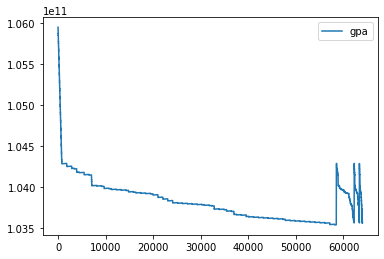

In [4]:
original.plot()

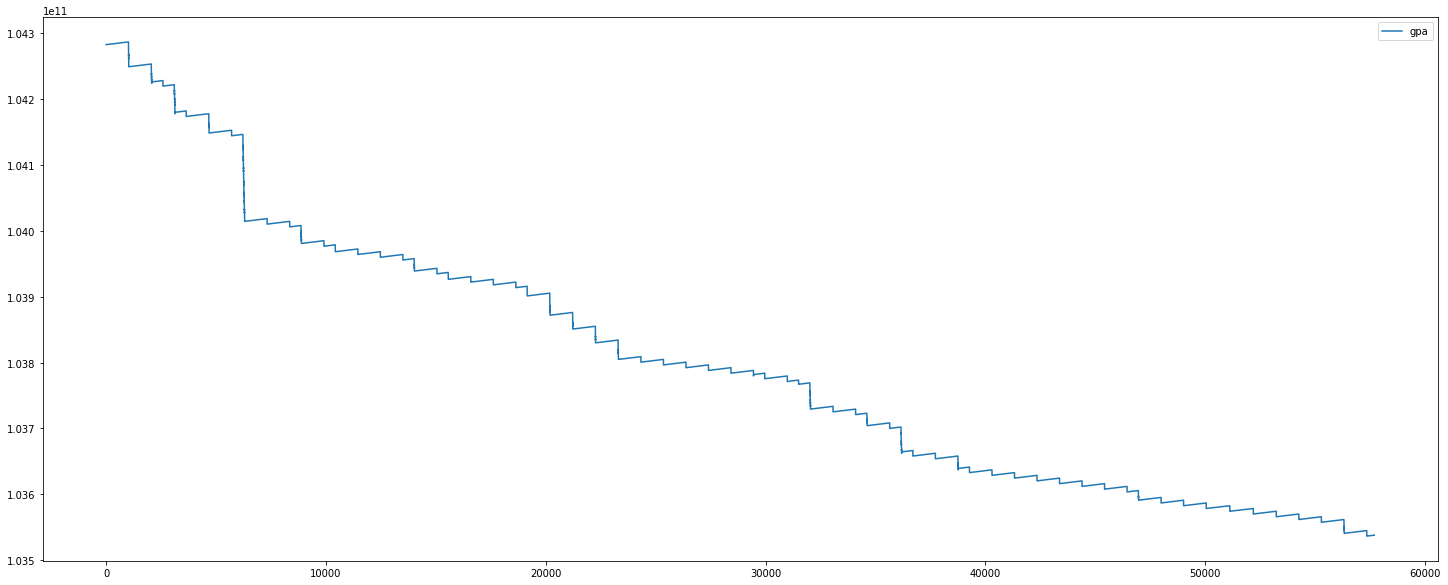

In [5]:
data = original[800:58486].copy().reset_index(drop=True)
data.plot(figsize=(25,10))

In [6]:
len(data)

57686

In [7]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data))-step)])
    return delta

In [8]:
pattern_length = 4

delta = delta_slice(data, pattern_length)
delta

,gpa
0,16384
1,16384
2,16384
3,16384
4,16384
...,...
57677,16384
57678,16384
57679,16384
57680,16384


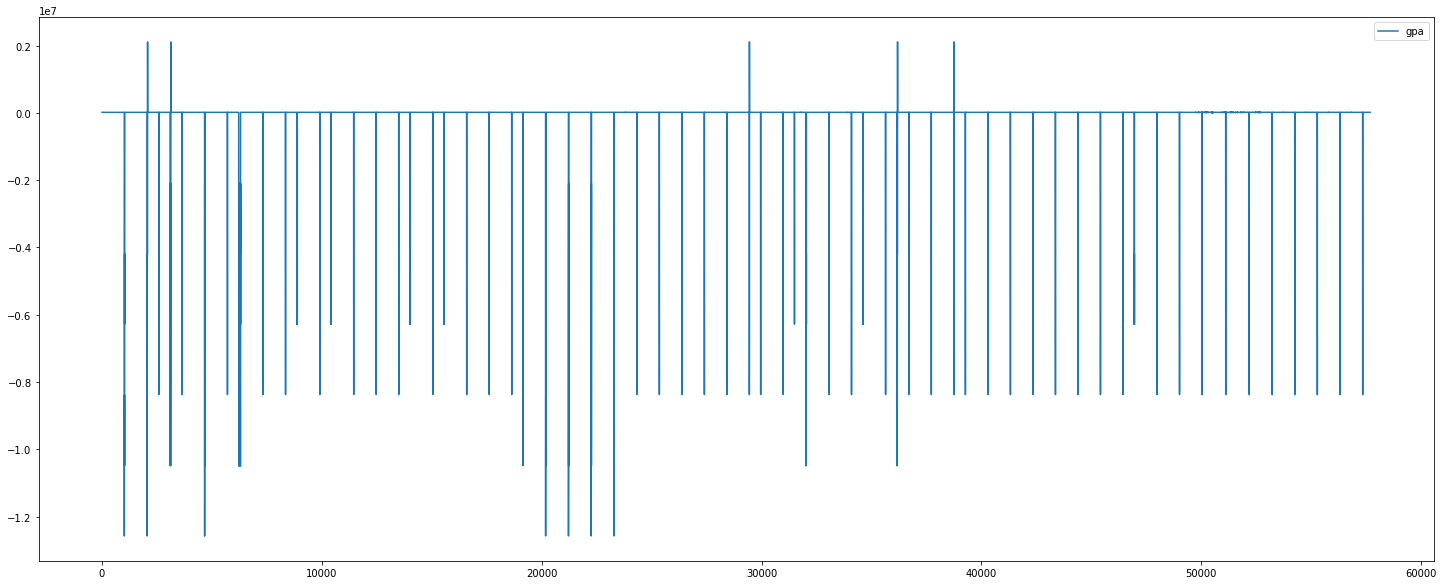

In [9]:
delta.plot(figsize=(25, 10))

In [10]:
split_index = 50000

train_set = delta[:split_index]
test_set = delta[split_index:].reset_index(drop=True)
train_set, test_set

(         gpa
 0      16384
 1      16384
 2      16384
 3      16384
 4      16384
 ...      ...
 49995  16384
 49996  16384
 49997  16384
 49998  16384
 49999  16384
 
 [50000 rows x 1 columns],
         gpa
 0     16384
 1     16384
 2     16384
 3     16384
 4     12288
 ...     ...
 7677  16384
 7678  16384
 7679  16384
 7680  16384
 7681  16384
 
 [7682 rows x 1 columns])

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

train_data_scaled = minmax_scaler.fit_transform(train_set.values)
train_data_scaled

array([[0.85750139],
       [0.85750139],
       [0.85750139],
       ...,
       [0.85750139],
       [0.85750139],
       [0.85750139]])

In [12]:
def generate_timeseries(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels)

In [13]:
PAST_HISTORY = 16
FUTURE_TARGET = 8
TRAIN_SPLIT = 40000
BATCH_SIZE = 256
BUFFER_SIZE = 200000

In [35]:
x_train, y_train = generate_timeseries(train_data_scaled, 0, TRAIN_SPLIT, PAST_HISTORY, FUTURE_TARGET)
x_val, y_val = generate_timeseries(train_data_scaled, TRAIN_SPLIT, None, PAST_HISTORY, FUTURE_TARGET)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [15]:
def plot_graphs(history, metric, title=None):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    if title:
        plt.savefig("result/{0}-{1}.png".format(metric, title), dpi=300)
    plt.show()

In [36]:
num_neurons_1 = 128
num_neurons_2 = 128
dropout_rate = 0.2

EPOCHS = 500
EVALUATION_INTERVAL = 156
VAL_STEPS = 39
title = '{0}-{1}-{2}_{3}_{4}'.format(EPOCHS, BATCH_SIZE, num_neurons_1, num_neurons_2, dropout_rate)

In [17]:
import joblib

joblib.dump(minmax_scaler, "scaler/minmax-scaler_{0}.pkl".format(title))

['models/minmax-scaler_1000-256-128_128_0.2.pkl']

In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(num_neurons_1, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(num_neurons_2))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(FUTURE_TARGET))
model.add(tf.keras.layers.Activation("relu"))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [39]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_steps=VAL_STEPS, validation_data=val_data,  callbacks=[tensorboard_callback])

=============] - 1s 7ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0055 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0044
Epoch 382/500
156/156 [==============================] - 1s 7ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0055 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0043
Epoch 383/500
156/156 [==============================] - 1s 8ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0053 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0048
Epoch 384/500
156/156 [==============================] - 1s 8ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0057 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0032
Epoch 385/500
156/156 [==============================] - 1s 7ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0053 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0041
Epoch 386/500
156/156 [==============================] - 1s 7ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0059 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0029
Epoch 387/500
156/156 [===============

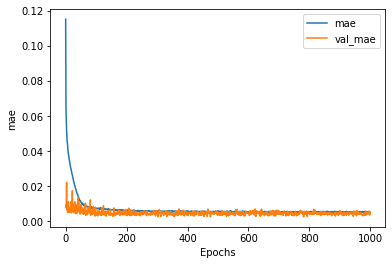

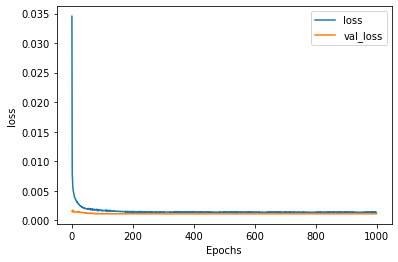

In [21]:
pd.DataFrame.from_dict(model_history.history).to_csv("result/{0}.csv".format(title), index=False)
plot_graphs(model_history, 'mae', title)
plot_graphs(model_history, 'loss', title)

In [22]:
model.save("models/{0}.h5".format(title))

In [23]:
test_data_nomalized = minmax_scaler.transform(test_set)
x_test, y_test = generate_timeseries(test_data_nomalized, 0, None, PAST_HISTORY, FUTURE_TARGET)

In [24]:
from sklearn.metrics import mean_squared_error

def plot_test_error(model, x_test, y_test, title=None):
    test_preds = []
    test_errors = []
    for x, y in zip(x_test, y_test):
        x_pred = model.predict(x.reshape(1, -1, 1))
        test_preds.append(x_pred)
        test_errors.append(mean_squared_error(y.reshape(1, -1), x_pred))
    test_errors = pd.DataFrame(data=[test_errors]).T
    test_errors.columns = ["Test MSE"]
    test_plot = test_errors.plot(figsize=(25, 10))
    test_plot.set_ylim(0, 0.04)
    if title:
        test_errors.to_csv("result/test_mse-{0}.csv".format(title), index=False)
        test_plot.figure.savefig("result/test_mse-{0}.png".format(title), dpi=300)
    plt.show()
    return test_preds, test_errors

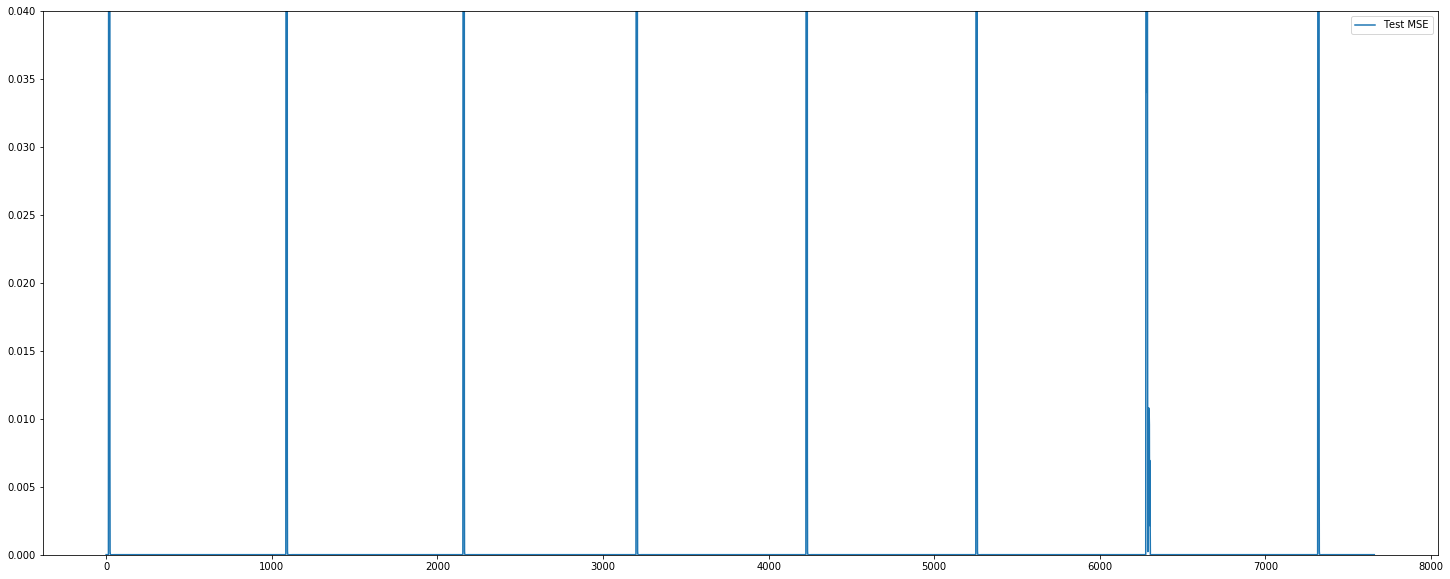

In [25]:
test_preds, test_errors = plot_test_error(model, x_test, y_test, title)

In [29]:
test_errors["Test MSE"].value_counts()

0.000010    5917
0.000010      36
0.000009      34
0.000009      34
0.000009      33
            ... 
0.000328       1
0.000009       1
0.000009       1
0.000009       1
0.000010       1
Name: Test MSE, Length: 683, dtype: int64